In [1]:
import sys, os

from pathlib import Path
import pprint

import math
import numpy as np
import pandas as pd
import GPy
import GPyOpt
from GPyOpt.acquisitions import AcquisitionEI, AcquisitionLCB, AcquisitionMPI
from GPyOpt.methods import BayesianOptimization

from GPyOpt import Design_space  ## GPyOpt design space
from GPyOpt.models import GPModel

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from skopt.sampler import Lhs

from matplotlib import pyplot as plt

sys.path.append('./lib/') #change to your path to "lib" if this notebook is located in another directory than lib
from DataManager import DataManager as DM
from prepare_db import prepare_dmdir
import utils

### Set up path variables ### 
root = Path.cwd() # change to your project directory if this notebook is located not in project dir
prepare_dmdir(root) # ensuring that dir and subdir exists. Otherwise they will be created
ref_data = root/'reference' # path to reference data (from ab-initio MD)
dm_dir = root/'grid' # folders with simulation data for each FF will be saved there
md_template = root/'md_template' #prepared "template" classical MD simulations

### Define DataManager
## Specify grid by {resid : {param_name : [min, max, n_nodes]}}
grid_spec = {'OE' : {'sigma' : [0.2, 0.6, 10], 'epsilon' : [0.1, 1.6, 10] }}
## Parameters to read force field file
ff_fname = 'ff.itp'
ff_start, ff_end = 5, 21
## DataManager
dm = DM(dm_dir, md_template, grid_spec, ff_fname, ff_start, ff_end)

### Specify objective function calculations
## Weight map to compute objective function {atom pair : weight coefficient}
weight_map = {'Li-OE' : 1,
#              'Li-OBT' : 1,
#              'Li-NBT' : 1,
#              'Li-Li' : 1,
#             'OE-OE' : 1,
#              'NBT-NBT' : 1,
             }
x_rdf_max = 1.25 # max radius of RDF computing
rdf_smooth = True # data smoothering 


### Grid parameters ### 

### Number of initial samples ###
N_s = 5


### GPR parameters ### 
l1, l2 = 0.55, 1.4
var_0 = 5 
var_n = 0.0002 #noise variance

kernel_type = 52
constrain_l = False
constrain_var = False
constrain_noise = False


### BO parameters ### 
N_iter = 50
jitter = 0.01 # explorative coefficient if EI is epmployed
# BO_lambda = 0.15 #to schedule w_exp
# w_exp = 0.05 # explorative coefficient if LCB is epmployed
w_exp = 0.0001 # explorative coefficient if LCB is epmployed
BO_lambda = 0.005 #to schedule w_exp
af_types = ['EI', 'LCB', 'VAR']
af_t = af_types[1]

RUN_CMD = """
gmx grompp -f em.mdp -p topol.top -c start.gro -o em.tpr
gmx mdrun -s em.tpr -deffnm em

gmx grompp -f equi.mdp -p topol.top -c em.gro -o equi.tpr
gmx mdrun -s equi.tpr -deffnm equi

gmx make_ndx -f equi.tpr -o index-rdf.ndx < make_ndx.inp

gmx rdf -f equi.xtc -s equi.tpr -n index-rdf.ndx -rmax 2.0 -tu ns -b 0.5 -e 1.0 -o rdf_Li-OE.xvg -cn crd_Li-OE.xvg -xvg none < rdf_Li-OE.inp
gmx rdf -f equi.xtc -s equi.tpr -n index-rdf.ndx -rmax 2.0 -tu ns -b 0.5 -e 1.0 -o rdf_Li-OBT.xvg -cn crd_Li-OBT.xvg -xvg none < rdf_Li-OBT.inp
gmx rdf -f equi.xtc -s equi.tpr -n index-rdf.ndx -rmax 2.0 -tu ns -b 0.5 -e 1.0 -o rdf_Li-NBT.xvg -cn crd_Li-NBT.xvg -xvg none < rdf_Li-NBT.inp
gmx rdf -f equi.xtc -s equi.tpr -n index-rdf.ndx -rmax 2.0 -tu ns -b 0.5 -e 1.0 -o rdf_OE-OBT.xvg -cn crd_OE-OBT.xvg -xvg none < rdf_OE-OBT.inp
gmx rdf -f equi.xtc -s equi.tpr -n index-rdf.ndx -rmax 2.0 -tu ns -b 0.5 -e 1.0 -o rdf_OE-NBT.xvg -cn crd_OE-NBT.xvg -xvg none < rdf_OE-NBT.inp
gmx rdf -f equi.xtc -s equi.tpr -n index-rdf.ndx -rmax 2.0 -tu ns -b 0.5 -e 1.0 -o rdf_OE-OE.xvg -cn crd_OE-OE.xvg -xvg none < rdf_OE-OE.inp
gmx rdf -f equi.xtc -s equi.tpr -n index-rdf.ndx -rmax 2.0 -tu ns -b 0.5 -e 1.0 -o rdf_Li-Li.xvg -cn crd_Li-Li.xvg -xvg none < rdf_Li-Li.inp
gmx rdf -f equi.xtc -s equi.tpr -n index-rdf.ndx -rmax 2.0 -tu ns -b 0.5 -e 1.0 -o rdf_NBT-NBT.xvg -cn crd_NBT-NBT.xvg -xvg none < rdf_NBT-NBT.inp
"""

Warning! Directory /media/sf_Documents/GitHub/FFoptimizer/pic already exists. The original directory is not modified.
Warning! Directory /media/sf_Documents/GitHub/FFoptimizer/grid already exists. The original directory is not modified.
	 Checking _nodes.json file...Exists! ... success!
Initialization: database /media/sf_Documents/GitHub/FFoptimizer/grid ... already exists! Checking  _nodes.json file ....
Success! Database manager is created!!!


In [2]:
dm.md_templ/"equi.mdp"

PosixPath('/media/sf_Documents/GitHub/FFoptimizer/md_template/equi.mdp')

### Search space definition
It is assumed that there is a 'target' reference FF parameter set,
which is provided with the specified md-template. 

If FF in the template are arbitrary, just ignore next snippet.

You can switch off annotationg of 'target' point by passing None as a corresponding parameter
in plot2D_BO

In [3]:

ff_path = md_template/'ff.itp'
df = dm._read_ff_file(ff_path)
pdict_target = {}
for resid in grid_spec:
    pdict_target[resid] = {}
    for param_name, param_value in grid_spec[resid].items():
        pdict_target[resid][param_name] = float(df.at[resid, param_name])
plist_target = dm.convert_to_plist(pdict_target)
print('target pdict : ', pdict_target)
print('target plist : ', plist_target)

target pdict :  {'OE': {'sigma': 0.29, 'epsilon': 0.58576}}
target plist :  [0.58576, 0.29]


space - a search space is defined according to grid_spec of DataManager dm. It is to pass a parameter to GPy optimizer.

X_grid = array of coordinates of all nodes

In [4]:
### build a search space ###
## according to specified grid_spec
design_space_ar = []
for resid, param in dm.params:
    x_min, x_max, n_x = dm.grid_spec[resid][param]
    x_name = resid + '_' + param
    entry = {'name': x_name, 'type': 'continuous', 'domain':(x_min, x_max), 'dimensionality':1}
    design_space_ar.append(entry)
space = Design_space(design_space_ar)

X_grid = np.meshgrid(*dm.nodes)
X_grid = np.array(X_grid)
X_grid = X_grid.T.reshape(-1, 2)

### Initial sampling

N_s points are sampled at start using Latin-hypercube sampling techniqu

In [5]:
lhs_sampler = Lhs(lhs_type="classic", criterion='maximin') # createrion maximin to maximaze min pdist
X = lhs_sampler.generate(dm.bounds, N_s, random_state=1)

Y = []
for x in X:
    pdict = dm.convert_to_pdict(x)
    case_dirpath = dm.create_case(pdict)
    utils.run_md_case(case_dirpath, RUN_CMD, verbose=False)
    cost = utils.compute_total_cost(case_dirpath, ref_data, weight_map, x_max=x_rdf_max)
    Y.append(cost)


DataManager Warning! The casedir 003_009 already exists, no changes are made. The existing MD configuration will be used
DataManager Warning! The casedir 007_007 already exists, no changes are made. The existing MD configuration will be used
DataManager Warning! The casedir 004_002 already exists, no changes are made. The existing MD configuration will be used
DataManager Warning! The casedir 008_000 already exists, no changes are made. The existing MD configuration will be used
DataManager Warning! The casedir 000_005 already exists, no changes are made. The existing MD configuration will be used


## Optimization loop
just start and enjoy. The results are shown here after the optimization loop is terminated. Otherwise, the snapshots at each iteration are saved in **root/pics** and can be checked online. The predictions at each iteration and checked data points are saved at each iteration in **root/history.npy** and **root/X.npy** correspondingly.

Loading results of initial sampling ... WARNING: get_multiidx: nodes coordinates don't match with point coordinates. However, the closest multiidx is found and ff parameters are set according to grid node at this multiidx 
DataManager Warning! The casedir 003_009 already exists, no changes are made. The existing MD configuration will be used
Point  {'OE': {'epsilon': 0.5942671379594067, 'sigma': 0.5966551522905743}} ; cost =  11.561399935646554
DataManager Warning! The casedir 007_007 already exists, no changes are made. The existing MD configuration will be used
Point  {'OE': {'epsilon': 1.2220554706689961, 'sigma': 0.5092221677846325}} ; cost =  12.28782626926246
DataManager Warning! The casedir 004_002 already exists, no changes are made. The existing MD configuration will be used
Point  {'OE': {'epsilon': 0.7399158426429852, 'sigma': 0.2890085103366857}} ; cost =  9.367280608148834
DataManager Warning! The casedir 008_000 already exists, no changes are made. The existing MD configu

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
              :-) GROMACS - gmx grompp, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenh

Analysing residue names:
There are:     4      Other residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.084 0.084 0.084
This run will generate roughly 11 Mb of data


Compiled SIMD: SSE2, but for this host/run SSE4.1 might be better (see log).
The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file em.tpr, VERSION 2020.1-Ubuntu-2020.1-1 (single precision)

Using 1 MPI thread

Non-default thread affinity set, disabling internal thread affinity

Using 1 OpenMP thread 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+02
   Number of steps    =        20000

writing lowest energy coordinates.

Steepest Descents converged to Fmax < 100 in 1343 steps
Potential Energy  = -9.5801550e+02
Maximum force     =  9.2222443e+01 on atom 223
Norm of force     =  3.0899922e+01

GROMACS reminds you: "It's Because Of the Metric System" (Pulp Fiction)

              :-) GROMACS - gmx grompp, 2020.1-Ubuntu-2020.1-1 (-:

                     

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     4      Other residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 350 K
Calculated rlist for 1x1 atom pair-list as 1.020 nm, buffer size 0.010 nm
Set rlist, assuming 4x4 atom pair-list, to 1.010 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 20x20x20, spacing 0.101 0.101 0.101
This run will generate roughly 3 Mb of data


starting mdrun 'PEO14xN2_LiTFSI2'
500000 steps,   1000.0 ps.

Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:      354.118      354.120      100.0
                 (ns/day)    (hour/ns)
Performance:      243.985        0.098

GROMACS reminds you: "These are Ideas, They are Not Lies" (Magnapop)

sh: 8: cannot open make_ndx.inp: No such file
               :-) GROMACS - gmx rdf, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lin

Reading frame     200 time    0.900   
Analyzed 251 frames, last time 1000.000

GROMACS reminds you: "Come on boys, Let's push it hard" (P.J. Harvey)

               :-) GROMACS - gmx rdf, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tielema

Reading frame     200 time    0.900   
Analyzed 251 frames, last time 1000.000

GROMACS reminds you: "Step Aside, Butch" (Pulp Fiction)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
              :-) GROMACS - gmx grompp, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. 

Analysing residue names:
There are:     4      Other residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.084 0.084 0.084
This run will generate roughly 11 Mb of data



writing lowest energy coordinates.

Steepest Descents converged to Fmax < 100 in 362 steps
Potential Energy  = -2.3793354e+03
Maximum force     =  7.9399132e+01 on atom 223
Norm of force     =  2.6279471e+01

GROMACS reminds you: "I never thought of stopping, and I just hated sleeping. I can't imagine having a better life." (Barbara McClintock)

              :-) GROMACS - gmx grompp, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik M

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     4      Other residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 350 K
Calculated rlist for 1x1 atom pair-list as 1.010 nm, buffer size 0.000 nm
Set rlist, assuming 4x4 atom pair-list, to 1.010 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 20x20x20, spacing 0.101 0.101 0.101
This run will generate roughly 3 Mb of data



Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:      376.840      376.841      100.0
                 (ns/day)    (hour/ns)
Performance:      229.275        0.105

GROMACS reminds you: "There are only two things wrong with C++:  The initial concept and the implementation." (Bertrand Meyer)

sh: 8: cannot open make_ndx.inp: No such file
               :-) GROMACS - gmx rdf, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindah

Reading frame     200 time    0.900   
Analyzed 251 frames, last time 1000.000

GROMACS reminds you: "If all else fails, immortality can always be assured by spectacular error." (John Kenneth Galbraith)

               :-) GROMACS - gmx rdf, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    

Reading file equi.tpr, VERSION 2020.1-Ubuntu-2020.1-1 (single precision)
Reading frame     200 time    0.900   
Analyzed 251 frames, last time 1000.000

GROMACS reminds you: "Here are all the 'gmx' tools... but no gmx writethesis" (Christian Blau)

               :-) GROMACS - gmx rdf, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pro

Analyzed 251 frames, last time 1000.000

GROMACS reminds you: "I originally implemented PME to prove that you didn't need it..." (Erik Lindahl)

              :-) GROMACS - gmx grompp, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman   

Analysing residue names:
There are:     4      Other residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.084 0.084 0.084
This run will generate roughly 11 Mb of data



writing lowest energy coordinates.

Steepest Descents converged to Fmax < 100 in 1467 steps
Potential Energy  = -9.9856665e+02
Maximum force     =  9.7924759e+01 on atom 223
Norm of force     =  2.8487988e+01

GROMACS reminds you: "I originally implemented PME to prove that you didn't need it..." (Erik Lindahl)

              :-) GROMACS - gmx grompp, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pie

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     4      Other residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 350 K
Calculated rlist for 1x1 atom pair-list as 1.019 nm, buffer size 0.009 nm
Set rlist, assuming 4x4 atom pair-list, to 1.010 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 20x20x20, spacing 0.101 0.101 0.101
This run will generate roughly 3 Mb of data



Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:      336.528      336.528      100.0
                 (ns/day)    (hour/ns)
Performance:      256.740        0.093

GROMACS reminds you: "Chemical gases filling lungs of little ones" (Black Eyed Peas)

sh: 8: cannot open make_ndx.inp: No such file
               :-) GROMACS - gmx rdf, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   


Reading frame     200 time    0.900   
Analyzed 251 frames, last time 1000.000

GROMACS reminds you: "Science is the great antidote to the poison of enthusiasm and superstition." (Adam Smith, Wealth of Nations, 1776)

               :-) GROMACS - gmx rdf, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Mich

Reading file equi.tpr, VERSION 2020.1-Ubuntu-2020.1-1 (single precision)
Reading file equi.tpr, VERSION 2020.1-Ubuntu-2020.1-1 (single precision)
Reading frame     200 time    0.900   
Analyzed 251 frames, last time 1000.000

GROMACS reminds you: "A cop pulls Heisenberg over and asks him 'Do you know how fast you were going?' Heisenberg replies 'No, but I know exactly where I am'. The cop says 'You were doing 55 in a 35 zone'. Heisenberg: 'Great! Now I'm lost!" (Anonymous)

               :-) GROMACS - gmx rdf, 2020.1-Ubuntu-2020.1-1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasso

Reading frame     200 time    0.900   
Analyzed 251 frames, last time 1000.000

GROMACS reminds you: "Documentation is like sex: When it's good it's great, and when it's bad it's better than nothing." (Linus Torvalds)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


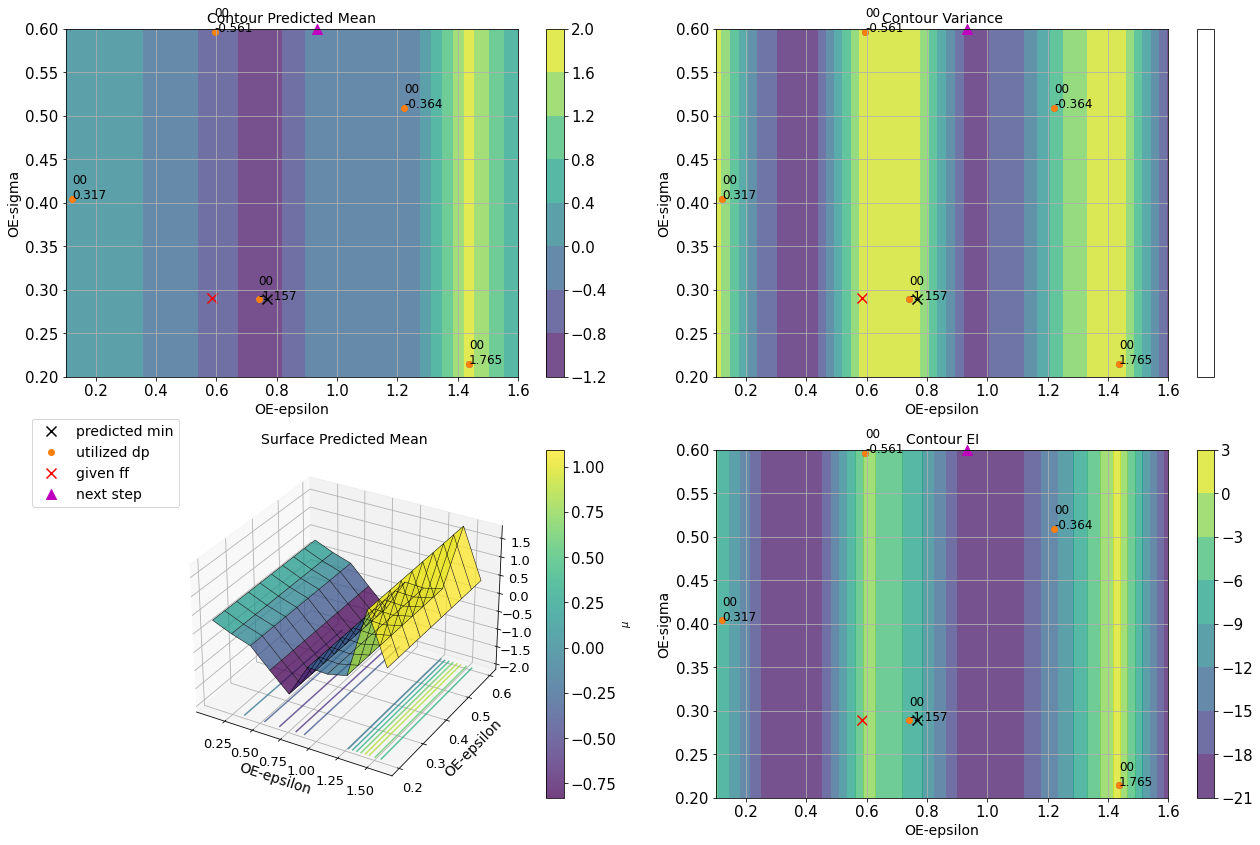

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


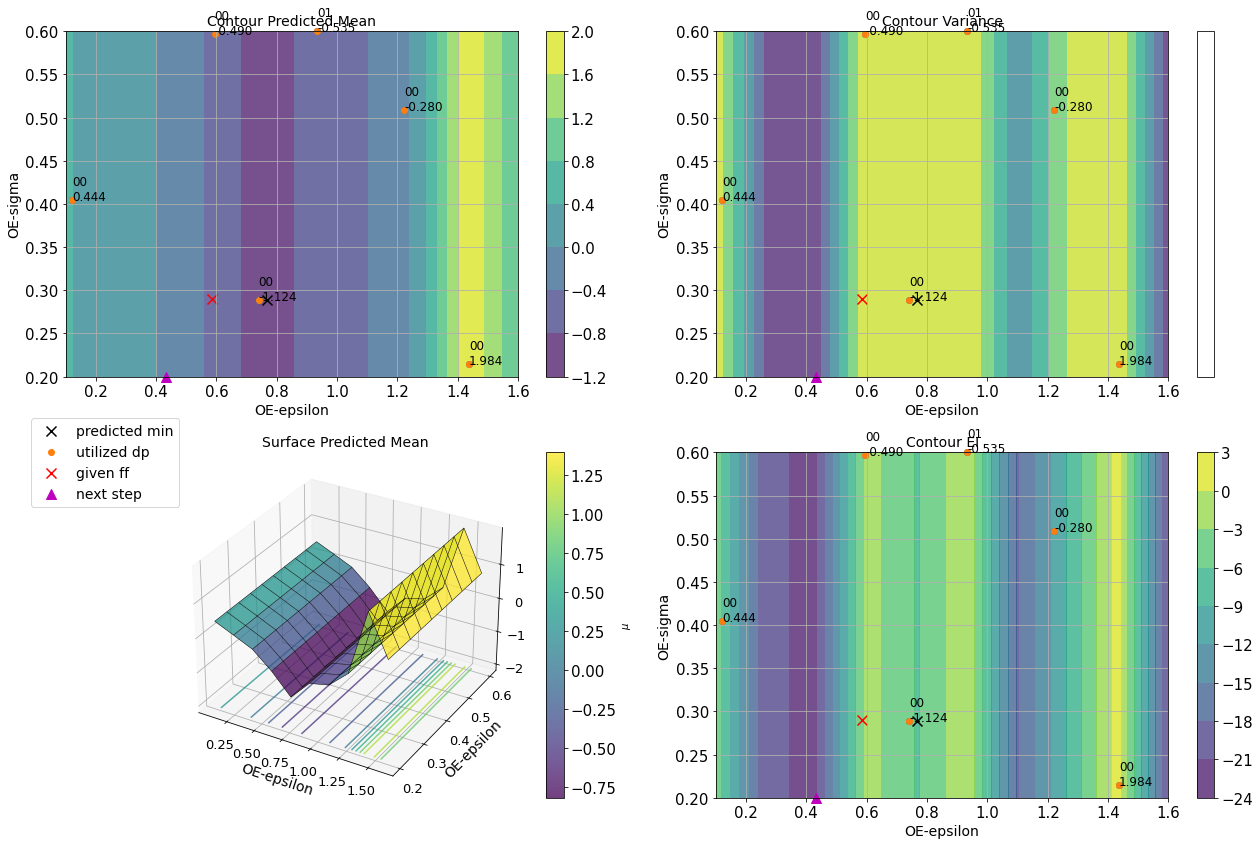

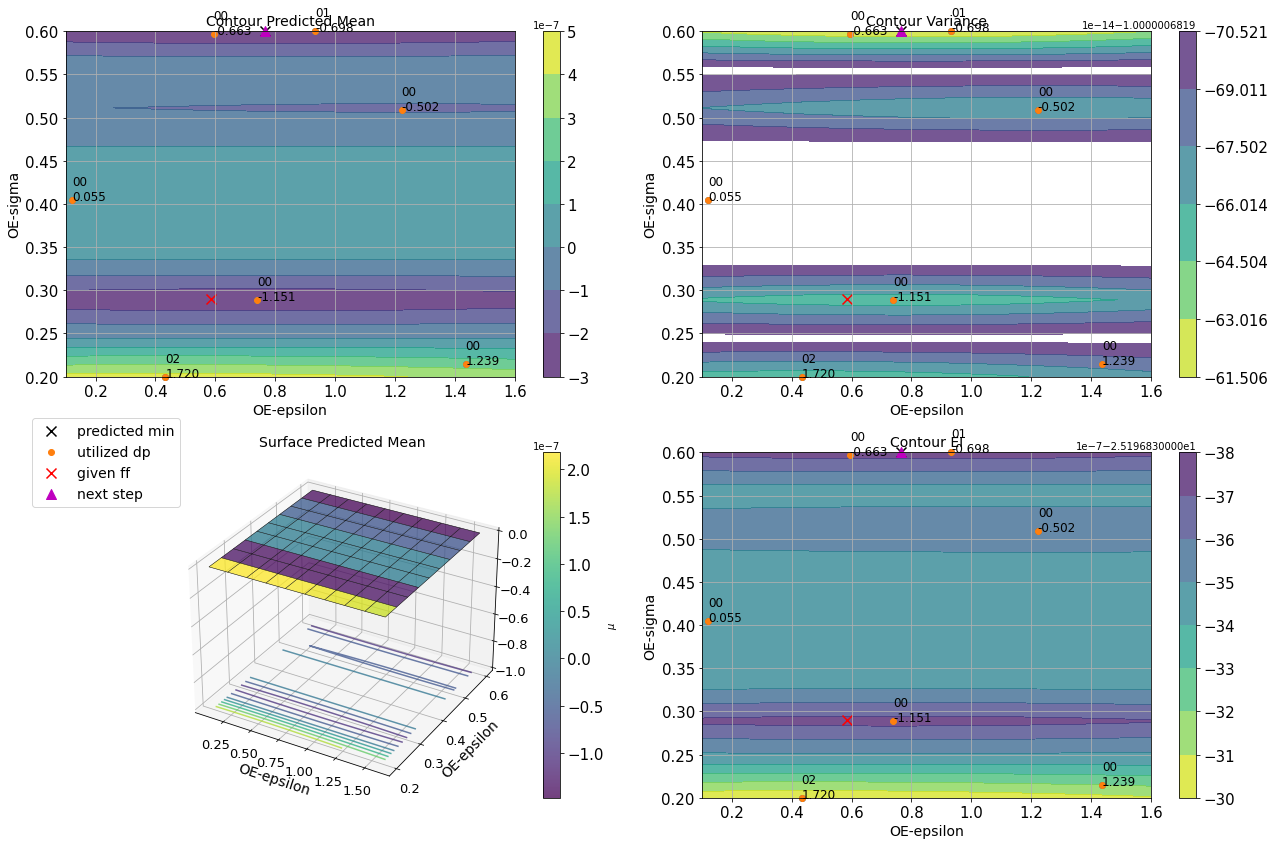

In [6]:
lhs_sampler = Lhs(lhs_type="classic", criterion='maximin') # createrion maximin to maximaze min pdist
X = lhs_sampler.generate(dm.bounds, N_s, random_state=1)

print('Loading results of initial sampling ... ', end='')
Y = []
for x in X:
    pdict = dm.convert_to_pdict(x)
    case_dirpath = dm.create_case(pdict)
    utils.run_md_case(case_dirpath, RUN_CMD, verbose=False)
    cost = utils.compute_total_cost(case_dirpath, ref_data, weight_map, x_max=1.25)
    Y.append(cost) 
    print('Point ', pdict, '; cost = ', cost)
print('... done!')   
print('Starting optimization')

# Annots = [ '00\n'+f'{y[0]:2.3e}' for y in Y0]
route_cols = ['x_min', 'x_next']
route = []

history_cols = ['mean', 'variance', 'acq_func']
history = []

scaler = preprocessing.StandardScaler()
Y = np.array(Y)[:, np.newaxis]
X = np.array(X)

#for n_iter in range(N_iter):
for n_iter in range(3):
    Y_norm = scaler.fit_transform(Y)
    
    Annots = [ '00\n'+f'{y[0]:1.3f}' for y in Y_norm[:N_s]] #annotating points smapled initially as '00'
    for j in range(n_iter):
        y_ = Y_norm[N_s + j][0]
        Annots.append(f'{j+1:02d}\n'+f'{y_:1.3f}')
    #Annots = Annots + [f'{n_iter:02d}\n'+f'{y_[0]:1.3f}' for y_ in Y_norm[4:]] # annotating following points 
    
    
    ### configuring kernel and GP hyperparameters ###
    if kernel_type == 32:
        ker = GPy.kern.Matern32(2, ARD=True)
        m = GPy.models.GPRegression(X, Y_norm, ker)
        model = GPModel(verbose=True)
        model.model = m
        if constrain_l:
            m.Mat32.lengthscale[[0]].constrain_fixed(l1)
            m.Mat32.lengthscale[[1]].constrain_fixed(l2)
        if constrain_var:
            m.Mat32.variance.constrain_fixed(var_0)
        if constrain_noise:  
            m.Gaussian_noise.constrain_fixed(var_n)
    elif kernel_type == 52:
        ker = GPy.kern.Matern52(2, ARD=True)
        m = GPy.models.GPRegression(X, Y_norm, ker)
        model = GPModel(verbose=True)
        model.model = m
        if constrain_l:
            m.Mat52.lengthscale[[0]].constrain_fixed(l1)
            m.Mat52.lengthscale[[1]].constrain_fixed(l2)
        if constrain_var:
            m.Mat52.variance.constrain_fixed(var_0)
        if constrain_noise:  
            m.Gaussian_noise.constrain_fixed(var_n)
    else:
        print("KERNEL ERROR! Check variable 'kernel_type'")
              
    m.optimize('bfgs', max_iters=100) # optimization of GP hyperparameters

    ### prediction over X_grid ###
    mean, Cov = m.predict(X_grid, full_cov=True)
    mean = mean[:, 0]
    variance = np.diag(Cov)
    
    ### computation of acquisition function, finding x_next = argmin(acq_func) ###
    if af_t == 'EI':
        acq_func= AcquisitionEI(model,space, jitter = jitter)
    elif af_t =='VAR':
        acq_func= AcquisitionEI(model,space, jitter = 1e8) # making jitter big => pure exploration
    elif af_t == 'LCB':
        BO_beta = 2 * math.log(len(X_grid) * math.pow(n_iter+1,2) * math.pow(np.pi,2) / (6 * BO_lambda) )
        acq_func = GPyOpt.acquisitions.LCB.AcquisitionLCB(model,space, exploration_weight = BO_beta)
    else:
        print("ACQ. FUNC. ERROR! Check variable 'kernel_type'")
        break
    
    if af_t =='VAR':
        next_sample_index = np.argmax(variance)
    else:
        alpha_full = acq_func.acquisition_function(X_grid)[:, 0]
        next_sample_index = np.argmin(alpha_full)
        
    x_next = X_grid[next_sample_index]
    
    min_pred_index = np.argmin(mean)
    
    ### plotting and saving results at the current iteraton ###
    savepath=f'{root}/pic/step{n_iter:03d}'
    ax_labels = [p[0]+'-'+p[1] for p in dm.params] # e.g., p=['Li', 'sigma'] => ax_lbl = 'Li-sigma'
    utils.plot2D_BO(*dm.nodes, X, mean, variance * -1, alpha_full, 
                   plist_new=x_next, plist_target=plist_target, 
                   ax_labels = ax_labels, fs=14, fs_ax=15, 
                   cmap='viridis', savepath=savepath, 
                   annotations=Annots)
    history.append((mean, variance, alpha_full))
    np_history = np.array(history)
    np.save(root/'history.npy', np_history)
    np.save(root/'X.npy', X)
    
    ###running simulation for next iteration, computing cost function
    pdict_next = dm.convert_to_pdict(x_next)
    case_dirpath_next = dm.create_case(pdict_next)
    utils.run_md_case(case_dirpath_next, RUN_CMD, verbose=False)
    
    y = utils.compute_total_cost(case_dirpath_next, ref_data, weight_map, x_max=x_rdf_max)
    #Y = np.concatenate((Y, y[:, np.newaxis]))    
    Y = np.concatenate((Y, np.array([[y]])))    
    X = np.concatenate((X, np.array([x_next])))
    
